<a href="https://colab.research.google.com/github/kridtapon/WFO-Confluence-Breakout-System/blob/main/WFO_Confluence_Breakout_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.4 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
<ipython-input-5-d258e28bf413>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d258e28bf413>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d258e28bf413>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return


Walk-Forward Optimization Results:
   Year       Best_Params  Test_Return
0  2020  (5, 21, 91, 101)     0.003500
1  2021  (5, 21, 51, 176)     0.020279
2  2022  (5, 21, 51, 176)     0.000000
3  2023  (5, 21, 51, 181)     0.178982
4  2024  (5, 21, 51, 166)     0.614667
5  2025  (5, 21, 51, 131)     0.000000


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           270851.845821
Total Return [%]                       170.851846
Benchmark Return [%]                   104.995917
Max Gross Exposure [%]                      100.0
Total Fees Paid                        709.487882
Max Drawdown [%]                        19.988531
Max Drawdown Duration                       541.0
Total Trades                                    4
Total Closed Trades                             3
Total Open Trades                               1
Open Trade PnL                      138830.488953
Win Rate [%]                            33.333333
Best Trade [%]                          52.880776
Worst Trade [%]                        -13.626995
Avg Winning Trade [%]                   52.880776
Avg Losing Trade [%]                    -6.814081


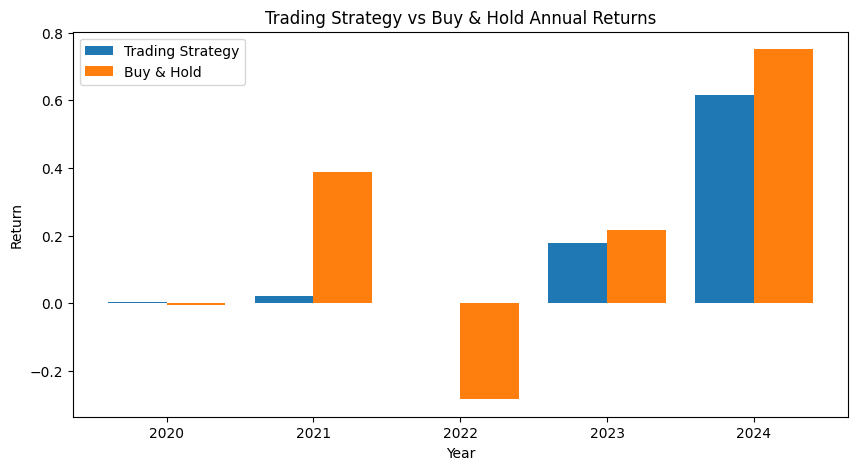

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Exponential Moving Averages (EMAs) with reusable parameters
def calculate_emas(df, close_col='Close', periods=None):
    if periods is None:
        periods = [20, 50, 100, 200]  # Default periods if none are provided

    for period in periods:
        df[f'EMA_{period}'] = df[close_col].ewm(span=period, adjust=False).mean()
    return df

# Function to detect confluence zone with reusable periods
def detect_confluence(df, periods=None):
    if periods is None:
        periods = [20, 50, 100, 200]  # Default periods if none are provided

    ema_columns = [f'EMA_{period}' for period in periods]
    df['Confluence_Upper'] = df[ema_columns].max(axis=1)
    df['Confluence_Lower'] = df[ema_columns].min(axis=1)
    return df

# Walk-forward optimization with EMA and Confluence Zone strategy
def walk_forward_optimization_ema(df, start_year, end_year):
    results = []

    # Define dynamic ranges for EMA periods
    MA_1_range = range(5, 21)
    MA_2_range = range(21, 51, 2)
    MA_3_range = range(51, 101, 5)
    MA_4_range = range(101, 201, 5)

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of EMA periods
        for params in itertools.product(MA_1_range, MA_2_range, MA_3_range, MA_4_range):
            MA_1, MA_2, MA_3, MA_4 = params

            # Calculate EMAs on the training data
            train_data = calculate_emas(train_data, periods=[MA_1, MA_2, MA_3, MA_4])
            train_data = detect_confluence(train_data, periods=[MA_1, MA_2, MA_3, MA_4])

            # Generate entry and exit signals based on confluence zone
            entries = (train_data['Close'] > train_data['Confluence_Upper']) & (train_data['Volume'] > train_data['Volume'].rolling(20).mean() * 1.5)
            exits = (train_data['Close'] < train_data['Confluence_Lower'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (MA_1, MA_2, MA_3, MA_4)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply EMAs and confluence zone
        yearly_data = calculate_emas(yearly_data, periods=[best_params[0], best_params[1], best_params[2], best_params[3]])
        yearly_data = detect_confluence(yearly_data, periods=[best_params[0], best_params[1], best_params[2], best_params[3]])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['Close'] > yearly_data['Confluence_Upper']) & (yearly_data['Volume'] > yearly_data['Volume'].rolling(20).mean() * 1.5)
        exits = (yearly_data['Close'] < yearly_data['Confluence_Lower'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'SYF'  # AVGO DECK HWM SYF! TPR
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization with EMA strategy
results = walk_forward_optimization_ema(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply EMAs and confluence zone
    yearly_data = calculate_emas(yearly_data, periods=[params[0], params[1], params[2], params[3]])
    yearly_data = detect_confluence(yearly_data, periods=[params[0], params[1], params[2], params[3]])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['Close'] > yearly_data['Confluence_Upper']) & (yearly_data['Volume'] > yearly_data['Volume'].rolling(20).mean() * 1.5)
    exits = (yearly_data['Close'] < yearly_data['Confluence_Lower'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [ ]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,204995.879476
Total Return [%],104.995879
Benchmark Return [%],104.995879
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],64.621658
